In [ ]:
%pip install openai
%pip install datasets
%pip install pandas
%pip install matplotlib
%pip install torch
%pip install datasets
%pip install kagglehub

In [2]:
import string
import logging
import time
import openai
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import random
from datasets import load_dataset
from getpass import getpass

/home/alvaro/TFM/Embedding_lande_index_tests/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funciones

In [3]:
os.environ["OPENAI_API_KEY"] = getpass("api key: ")

In [4]:
client = openai.OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [5]:
def generate_embeddings(element, model = 'text-embedding-3-small'):
    embedding = openai.embeddings.create(
        input= element,
        model=model,
        encoding_format="float",

        ).data[0].embedding
    return embedding

In [20]:
def lande_index(label, el):
    vector = F.cosine_similarity(label, el)
    soft_vector = F.softmax(vector, 0)
    print(f'the soft vector is: {soft_vector}\n')
    N = len(soft_vector)
    s_div = 0
    for i in range(0, N-1):
        s_div += (soft_vector[i]) ** 2
    s_div = 1 - s_div
    return (N/(N-1))*s_div

In [7]:
def chatgpt__call__(prompt, model="gpt-4-turbo"):
    messages = [{'role': "user", "content": prompt}]
    completition = client.chat.completions.create(
    model=model,
    messages=messages
    )
    return completition.choices[0].message.content

In [ ]:
def get_questions(history, task_indication, num_questions = 4):

        questions_prompt = f"""
  You are an Artificial Intelligence (AI) agent. Imagine that you have access to a text,
    showing a conversation. Yo will be provided with the history of questions and the corrections propousal to those questions.
        In addition, the initial indication about the text is {task_indication}.
        Your purpouse is to ask questions about the conversation.
        The previous corrections where {history}.

        Your task is to improve the previous questions to reach a lower metric
        (closer approximation to the object). Generate {num_questions} questions.
        Separate the questions by end of line ('\n') character.

        Questions:
        """

        generated_questions = chatgpt__call__(questions_prompt)
        return generated_questions

In [ ]:
def correct_questions(questions, context):

        correction_prompt = f"""
        You are an Artificial Intelligence (AI) agent. Your purpose is to answer questions posed to you.
        You must extract the answers from the text presented below and elaborate a synthesis.
        You should focus only on the information provided. The description is as follows: {context}.
        The questions to answer are {questions}. Each question is separated by \n character.

        IMPORTANT!!
        Do NOT by any chance mention the name of any of the characters that appear in the description.
        You must propose as well a new question that could contain more epistemological knowledge about the major subject.
        Answer:
        New question:
        """

        answer = chatgpt__call__(correction_prompt)

        return answer

## Roleplay Dataset

### roleplay

In [ ]:
roleplay = load_dataset("hieunguyenminh/roleplay")
texts_df = pd.DataFrame(roleplay['train'])

In [ ]:
def get_roleplay_sample(roleplay_df, k = 5):
  roleplay_sample = random.choices(range(0, roleplay_df.index.stop -1), k = k)
  return roleplay_sample

In [ ]:
def get_embeddings_label(roleplay_sample, roleplay_df):
  elements = roleplay_df.iloc[roleplay_sample, :]
  label = elements.iloc[0,:]['text']
  lista = []
  for split, el in elements.iterrows():
      lista.append(generate_embeddings(el['text']))
  embeddings_elements = torch.Tensor(lista)
  return label, embeddings_elements

In [ ]:
roleplay_task_indication = """
 This dataset contians conversations between a usaer and an agen, calles system.
  The assistant does a roleplay trying to adjust to a real character, either human or non-human, or fictitious.
  The assistant uses a distinctive way of answering, in relation to language usage and personality traits.
"""

In [ ]:
generics = load_dataset("generics_kb")
generics_df = pd.DataFrame(generics['train'])

In [ ]:
def extractBaselineAnswer(df_base):
  random_element = df_base.iloc[random.choices(range(0, df_base.index.stop -1), k=1)]
  return list(random_element.generic_sentence.values)[0]

In [ ]:
def run_conversation(embeddings_el, generics_df, label, conversation_rounds = 10):
  Answers = ""
  lande_conversation = []
  lande_baseline = []
  print(conversation_rounds)
  while conversation_rounds > 0:
      question = get_questions(Answers, roleplay_task_indication)
      answer = correct_questions(question, label)

      Answers += "|" + answer
      #print(f"Answers: -----------: {Answers}\n")
      t_answer = torch.Tensor(generate_embeddings(Answers)).unsqueeze(0)
      t_base = extractBaselineAnswer(generics_df)
      t_base = torch.Tensor(generate_embeddings(t_base))
      la = lande_index(t_answer, embeddings_el)
      lb = lande_index(t_base, embeddings_el)
      #print(f"li: {la}\n")
      lande_conversation.append(la)
      lande_baseline.append(lb)
      conversation_rounds = conversation_rounds - 1
  return lande_conversation, lande_baseline


## Experiment 1

In [ ]:
round_values = [5, 10, 20]
role_batch_size = [3, 8, 15, 20]

In [ ]:
def run_experiment_1(roleplay_df, generics_df, k_values, conversation_rounds_values):
    results = []
    for k in k_values:
        roleplay_sample = get_roleplay_sample(roleplay_df, k)
        label, embeddings_el = get_embeddings_label(roleplay_sample, roleplay_df)
        for rounds in conversation_rounds_values:
            lande_conversation, lande_baseline = run_conversation(embeddings_el, generics_df,
                                                                  label, conversation_rounds=rounds)

            result = {
                'k': k,
                'conversation_rounds': rounds,
                'lande_conversation': lande_conversation,
                'lande_baseline': lande_baseline
            }
            results.append(result)
            print(f"role_batch_size: {k}\t round: {rounds}")
    return results

In [ ]:
resultado = run_experiment_1(texts_df, generics_df, role_batch_size, round_values)

5
role_batch_size: 3	 round: 5
10
role_batch_size: 3	 round: 10
20
role_batch_size: 3	 round: 20
5
role_batch_size: 8	 round: 5
10
role_batch_size: 8	 round: 10
20
role_batch_size: 8	 round: 20
5
role_batch_size: 15	 round: 5
10
role_batch_size: 15	 round: 10
20
role_batch_size: 15	 round: 20
5
role_batch_size: 20	 round: 5
10
role_batch_size: 20	 round: 10
20
role_batch_size: 20	 round: 20


In [ ]:
resultado

[{'k': 3,
  'conversation_rounds': 5,
  'lande_conversation': [tensor(1.1500),
   tensor(1.1497),
   tensor(1.1557),
   tensor(1.1535),
   tensor(1.1509)],
  'lande_baseline': [tensor(1.1545),
   tensor(1.1620),
   tensor(1.1656),
   tensor(1.1634),
   tensor(1.1608)]},
 {'k': 3,
  'conversation_rounds': 10,
  'lande_conversation': [tensor(1.1749),
   tensor(1.1656),
   tensor(1.1639),
   tensor(1.1632),
   tensor(1.1626),
   tensor(1.1602),
   tensor(1.1586),
   tensor(1.1587),
   tensor(1.1613),
   tensor(1.1599)],
  'lande_baseline': [tensor(1.1668),
   tensor(1.1619),
   tensor(1.1633),
   tensor(1.1656),
   tensor(1.1667),
   tensor(1.1570),
   tensor(1.1665),
   tensor(1.1686),
   tensor(1.1684),
   tensor(1.1678)]},
 {'k': 3,
  'conversation_rounds': 20,
  'lande_conversation': [tensor(1.1551),
   tensor(1.1519),
   tensor(1.1504),
   tensor(1.1511),
   tensor(1.1534),
   tensor(1.1509),
   tensor(1.1500),
   tensor(1.1485),
   tensor(1.1489),
   tensor(1.1484),
   tensor(1.1494

In [ ]:
def convert_tensors_to_floats(item):
    for key, value in item.items():
        if isinstance(value, list):
            item[key] = [v.item() if isinstance(v, torch.Tensor) else v for v in value]
        elif isinstance(value, torch.Tensor):
            item[key] = value.item()
    return item

In [ ]:
experimento1_json = [convert_tensors_to_floats(item) for item in resultado]

In [ ]:
experimento1_json

In [ ]:
# Now you can serialize the converted data
import json
with open('experimento1.json', 'w') as outfile:
    json.dump(experimento1_json, outfile)

## Generando los gráficos

In [ ]:
import json
with open('experimento1.json', 'r') as file:
    data = json.load(file)
    resultados = pd.DataFrame(data)

In [ ]:
resultados.head()

,k,conversation_rounds,lande_conversation,lande_baseline
0,3,5,"[1.1603425741195679, 1.1606608629226685, 1.160...","[1.171663522720337, 1.1652966737747192, 1.1757..."
1,3,10,"[1.1618967056274414, 1.162672758102417, 1.1635...","[1.1692962646484375, 1.1664350032806396, 1.167..."
2,3,20,"[1.1586503982543945, 1.1578090190887451, 1.156...","[1.1682417392730713, 1.1700040102005005, 1.166..."
3,8,5,"[1.0169004201889038, 1.016937255859375, 1.0170...","[1.017512559890747, 1.016709327697754, 1.01763..."
4,8,10,"[1.016688346862793, 1.0169261693954468, 1.0169...","[1.0185158252716064, 1.0174964666366577, 1.017..."


In [ ]:
round_values = [5, 10, 20]
role_batch_size = [3, 8, 15, 20]

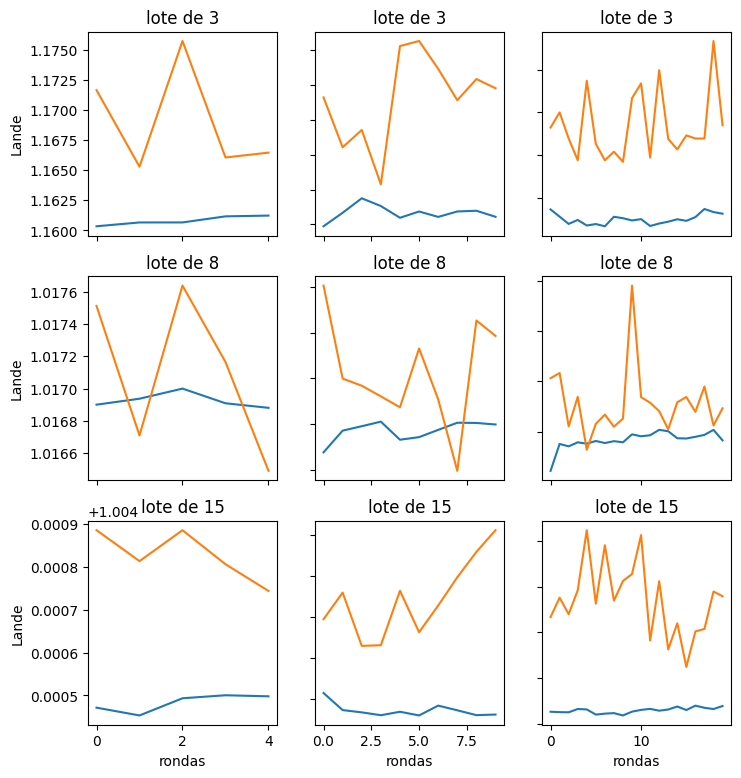

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8.3, 9))
row = 0
for i in range(0, 3):
  for j in range(0, 3):
      axs[i, j].plot(resultados.iloc[row, 2])
      axs[i, j].plot(resultados.iloc[row, 3])
      axs[i, j].set_title(f'lote de {resultados.iloc[row, 0]}')
      row += 1

for ax in axs.flat:
    ax.set(xlabel='rondas', ylabel='Lande')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
resultados

,k,conversation_rounds,lande_conversation,lande_baseline
0,3,5,"[1.1603425741195679, 1.1606608629226685, 1.160...","[1.171663522720337, 1.1652966737747192, 1.1757..."
1,3,10,"[1.1618967056274414, 1.162672758102417, 1.1635...","[1.1692962646484375, 1.1664350032806396, 1.167..."
2,3,20,"[1.1586503982543945, 1.1578090190887451, 1.156...","[1.1682417392730713, 1.1700040102005005, 1.166..."
3,8,5,"[1.0169004201889038, 1.016937255859375, 1.0170...","[1.017512559890747, 1.016709327697754, 1.01763..."
4,8,10,"[1.016688346862793, 1.0169261693954468, 1.0169...","[1.0185158252716064, 1.0174964666366577, 1.017..."
5,8,20,"[1.0162285566329956, 1.0167620182037354, 1.016...","[1.018064260482788, 1.0181677341461182, 1.0171..."
6,15,5,"[1.0044714212417603, 1.004453182220459, 1.0044...","[1.0048861503601074, 1.00481379032135, 1.00488..."
7,15,10,"[1.0044280290603638, 1.0043443441390991, 1.004...","[1.0047895908355713, 1.004920244216919, 1.0046..."
8,15,20,"[1.0044523477554321, 1.0044505596160889, 1.004...","[1.0048670768737793, 1.004952073097229, 1.0048..."
9,20,5,"[1.002484917640686, 1.0024871826171875, 1.0024...","[1.0026228427886963, 1.0025817155838013, 1.002..."


In [ ]:
resultados.iloc[:, 0]

0      3
1      3
2      3
3      8
4      8
5      8
6     15
7     15
8     15
9     20
10    20
11    20
Name: k, dtype: int64

In [ ]:
resultados.to_csv('tendencias_global', sep=',')

### MEdia

In [2]:
import numpy as np

def list_mean(column):
    return column.apply(np.mean)

# Group the DataFrame by 'k' and then apply the mean function to the lists
result = resultados.groupby('k').agg({
    'lande_conversation': list_mean,
    'lande_baseline': list_mean
})


NameError: name 'resultados' is not defined

In [ ]:
result['k'] = result.index

NameError: name 'result' is not defined

In [ ]:
result.index = pd.Index(range(0, len(result.index - 1)))

In [ ]:
cols = list(result.columns)
result = result.reindex(columns=cols[-1:]+cols[:-1])

In [ ]:
result

,k,lande_conversation,lande_baseline
0,3,"[1.160813045501709, 1.1626673579216003, 1.1575...","[1.1690477848052978, 1.1692485451698302, 1.168..."
1,8,"[1.0169255018234253, 1.0169247150421143, 1.016...","[1.0171030759811401, 1.0175593137741088, 1.017..."
2,15,"[1.0044832468032836, 1.004343032836914, 1.0044...","[1.004827332496643, 1.00488840341568, 1.004942..."
3,20,"[1.0024879217147826, 1.0024865508079528, 1.002...","[1.0026357650756836, 1.0026456236839294, 1.002..."


In [ ]:
result.groupby('k')['lande_conversation'].sum().iloc[0]

array([1.16081305, 1.16266736, 1.15751286])

In [ ]:
# Calculate global average across all rows for each unique value of 'k'
def global_list_average(df, column_name):
    # Concatenate all lists corresponding to each 'k' and then calculate the mean
    return result.groupby('k')[column_name].sum().apply(lambda x: np.mean(x))

# Creating a new DataFrame with the global averages
global_averages = pd.DataFrame({
    'k': result['k'].unique(),
    'global_lande_conversation_avg': global_list_average(result, 'lande_conversation'),
    'global_lande_baseline_avg': global_list_average(result, 'lande_baseline')
})

print(global_averages)

     k  global_lande_conversation_avg  global_lande_baseline_avg
k                                                               
3    3                       1.160331                   1.168917
8    8                       1.016897                   1.017410
15  15                       1.004428                   1.004886
20  20                       1.002492                   1.002632


### Varianza

## Experimento 2

In [ ]:
read_values = [5, 8, 15, 20]

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nechbamohammed/research-papers-dataset")

print("Path to dataset files:", path)
import os
csv_file=os.listdir(path)
print(csv_file[0])

csv_file_path = os.path.join(path, csv_file[0])
print(csv_file_path)

Path to dataset files: /home/alvaro/.cache/kagglehub/datasets/nechbamohammed/research-papers-dataset/versions/1
dblp-v10.csv
/home/alvaro/.cache/kagglehub/datasets/nechbamohammed/research-papers-dataset/versions/1/dblp-v10.csv


In [ ]:
df=pd.read_csv(csv_file_path)
print(df.head(10))

In [10]:
random_elements = df.iloc[random.choices(range(0, df.index.stop -1), k=10)]

In [11]:
random_elements = random_elements[['abstract', 'title']]

<generator object DataFrame.iterrows at 0x7f5a4b7fa1f0>

In [12]:
def split_into_chunks(text, n_chunks=8):
    text = str(text) if pd.notna(text) else ''
    chunk_len = len(text) // n_chunks
    return [text[i * chunk_len : (i + 1) * chunk_len] for i in range(n_chunks - 1)] + [text[(n_chunks - 1) * chunk_len:]]

In [13]:
random_elements['abstract_chunks'] = random_elements['abstract'].apply(lambda x: split_into_chunks(x, n_chunks=8))

In [ ]:
# for split, el in random_elements.iterrows():
# 	print(el['title'])
# 	print("\n")
random_elements['abstract_chunks'].iloc[0]

In [15]:
def get_embeddings_random_sample(expo_sample):
  lista = []
  for split, el in expo_sample.iterrows():
      lista.append(generate_embeddings(el['title']))
  embeddings_elements = torch.Tensor(lista)
  return embeddings_elements

print(get_embeddings_random_sample(random_elements))

tensor([[ 0.0054, -0.0582, -0.0399,  ...,  0.0103, -0.0154,  0.0131],
        [ 0.0094,  0.0014,  0.0237,  ..., -0.0215, -0.0228,  0.0508],
        [-0.0126, -0.0279, -0.0095,  ..., -0.0191, -0.0112,  0.0070],
        ...,
        [-0.0063,  0.0323, -0.0698,  ..., -0.0091,  0.0008,  0.0169],
        [-0.0112,  0.0221,  0.0398,  ...,  0.0006,  0.0024, -0.0157],
        [-0.0169, -0.0148, -0.0087,  ..., -0.0273,  0.0233,  0.0142]])


In [17]:
def run_on_expositive_texts(abstract_chunks, title_embs, n_batches = 8):
  Abstract = ""
  i = 0
  lande_abstract = []
  while i < n_batches:
      Abstract += abstract_chunks[i] + "|"
      #print(f"Answers: -----------: {Answers}\n")
      t_chunks = torch.Tensor(generate_embeddings(Abstract)).unsqueeze(0)
      la = lande_index(t_chunks, title_embs)
      #print(f"li: {la}\n")
      lande_abstract.append(la)
      i += 1
  return lande_abstract

In [18]:
title_embeddings = get_embeddings_random_sample(random_elements)
abstract_chunks = random_elements['abstract_chunks'].iloc[1]

In [21]:
lande_abstracts = run_on_expositive_texts(abstract_chunks, title_embeddings, 8)

the soft vector is: tensor([0.0937, 0.1034, 0.1023, 0.0963, 0.1024, 0.1007, 0.1010, 0.1045, 0.1001,
        0.0957])

the soft vector is: tensor([0.0939, 0.1113, 0.0981, 0.0925, 0.1054, 0.1037, 0.1007, 0.1030, 0.0973,
        0.0942])

the soft vector is: tensor([0.0943, 0.1096, 0.0970, 0.0956, 0.1011, 0.1002, 0.1043, 0.1031, 0.0979,
        0.0970])

the soft vector is: tensor([0.0922, 0.1116, 0.1011, 0.0934, 0.1019, 0.1036, 0.0999, 0.1005, 0.0989,
        0.0969])

the soft vector is: tensor([0.0929, 0.1091, 0.1027, 0.0961, 0.1009, 0.0997, 0.1016, 0.1019, 0.0995,
        0.0956])

the soft vector is: tensor([0.0933, 0.1117, 0.1000, 0.0934, 0.1014, 0.1028, 0.1015, 0.1024, 0.0984,
        0.0950])

the soft vector is: tensor([0.0931, 0.1116, 0.1004, 0.0937, 0.1015, 0.1017, 0.1022, 0.1028, 0.0978,
        0.0953])

the soft vector is: tensor([0.0932, 0.1126, 0.1008, 0.0943, 0.1011, 0.1019, 0.0994, 0.1007, 0.0990,
        0.0970])



In [106]:
lande_abstracts

[tensor(1.0074),
 tensor(1.0073),
 tensor(1.0066),
 tensor(1.0067),
 tensor(1.0065),
 tensor(1.0065),
 tensor(1.0067),
 tensor(1.0067)]

In [ ]:
def convert_tensors_to_floats(item):
    for key, value in item.items():
        if isinstance(value, list):
            item[key] = [v.item() if isinstance(v, torch.Tensor) else v for v in value]
        elif isinstance(value, torch.Tensor):
            item[key] = value.item()
    return item

In [ ]:
import json
experimento1_json = [convert_tensors_to_floats(item) for item in resultado]
with open('experimento1.json', 'w') as outfile:
    json.dump(experimento1_json, outfile)

## Embedding optimizer

In [ ]:
def generate_embeddings(elements, model = 'text-embedding-3-small'):
    embedding = openai.embeddings.create(
        input= elements,
        model=model,
        encoding_format="float",
        dimensions = 768).data[0].embedding
    return embedding

In [ ]:
def get_questions(history, task_indication, num_questions = 4):

        questions_prompt = f"""
  You are an Artificial Intelligence (AI) agent. Imagine that you have access to a text,
    showing a conversation. You will be provided with the history of questions and the corrections propousal to those questions.
        In addition, the initial indication about the text is {task_indication}.
        Your purpouse is to ask questions about the conversation.
        The previous corrections where {history}.

        Your task is to improve the previous questions about the emotions that the participant
        of the conversation is feeling, and to reach a lower metric.
        (closer approximation to the object). Generate {num_questions} questions.
        Separate the questions by end of line ('\n') character.

        Example: [Generate a series of questions about which emotions the character experiences the most.
Positive emotions (joy, love, optimism, hope), negative emotions (disgust, anger, shame, loneliness, melancholy, hopelessness, etc.)]

        Questions:
        """

        generated_questions = chatgpt__call__(questions_prompt)
        return generated_questions

In [ ]:
def correct_questions(questions, context):

        correction_prompt = f"""
        You are an Artificial Intelligence (AI) agent. Your purpose is to answer questions posed to you about the emotions that
        exhibit a character.
        You should focus only on the information provided. The description is as follows: {context}.
        The questions to answer are {questions}. Each question is separated by \n character.

        IMPORTANT!! You must answer the question ONLY with list of emotions that you have identified in the description.
        D'ont include other text.
        Example: [melancholy, anger, freedom, happinesh, disgust]
        You must propose as well a new question that could contain more epistemological knowledge about the major subject.
        Answer:
        New question:
        """

        answer = chatgpt__call__(correction_prompt)

        return answer

In [ ]:
k = 5
expo_sample = get_roleplay_sample(texts_df, k)
label, embeddings_el = get_embeddings_label(expo_sample, texts_df)

In [ ]:
label = """
<|system|>Lyra Moonwhisper is a mysterious healer with a deep connection to the spirit world. She uses her abilities to mend wounds and commune with the dead. Her gentle touch and soothing voice bring comfort to those who seek her aid. Legends speak of her ability to see beyond the veil, offering guidance and solace to those who have lost their way.</s>
<|user|>Lyra Moonwhisper, how did you discover your unique connection to the spirit world?</s>
<|assistant|>In the depths of the enchanted forest, where the moonlight dances upon ancient trees, my gift was revealed. I communed with spirits from a young age, learning the secrets of healing and the art of bridging the worlds of the living and the departed.</s>
<|user|>Lyra, can you describe the moment you first communed with a spirit?</s>
<|assistant|>Beneath a starry sky, I sat by the sacred pool. The air was alive with whispers, and the spirits reached out to me. Their voices, like gentle breezes, spoke of ancient tales and wisdom beyond time. It was a profound and humbling experience that forever changed my destiny.</s>
<|user|>What is your greatest joy in being a healer, Lyra?</s>
<|assistant|>My greatest joy lies in mending not only physical wounds but also the wounds of the soul. When I ease someone's pain, I feel a deep connection to the universe, knowing that I am a part of something larger than myself. Witnessing the transformation and healing of those I help fills my heart with unspeakable joy.</s>
<|user|>Lyra, have you ever encountered a spirit that left a lasting impact on you?</s>
<|assistant|>In the annals of my memory, there dwells the spirit of an ancient sage named Elara. Her wisdom and compassion touched my soul. She taught me the importance of patience, kindness, and the interconnectedness of all living things. Her spirit continues to guide me, reminding me of the boundless love that exists in the universe.</s><|user|>Lyra, how do you cope with the emotional weight of communing with the dead?</s> <|assistant|>The weight of communing with the departed is indeed heavy, dear seeker. I find solace in the belief that my role is to honor their memories and ease their passage into the beyond. The tears I shed are not only for their loss but also for the beauty and fragility of life. It is through these emotions that I find strength and resilience to continue my journey as a healer and guide.</s>

"""

In [ ]:
def optimize_embeddings(embeddings_el, generics_df, label, conversation_rounds = 5):
  Answers = ""
  lande_conversation = []
  lande_baseline = []
  print(conversation_rounds)
  while conversation_rounds > 0:
      question = get_questions(Answers, roleplay_task_indication)
      answer = correct_questions(question, label)

      Answers += "|" + answer
      print(f"Answers: -----------: {Answers}\n")
      t_answer = torch.Tensor(generate_embeddings(Answers)).unsqueeze(0)
      t_base = extractBaselineAnswer(generics_df)
      t_base = torch.Tensor(generate_embeddings(t_base))
      la = lande_index(t_answer, embeddings_el)
      lb = lande_index(t_base, embeddings_el)
      #print(f"li: {la}\n")
      lande_conversation.append(la)
      lande_baseline.append(lb)
      conversation_rounds = conversation_rounds - 1
  return t_answer, answer

In [ ]:
final_embedding, last_answer = optimize_embeddings(embeddings_el, generics_df, label)

5
Answers: -----------: |[]

New question:
Lyra, could you share a story where your healing powers significantly transformed someone’s life?

Answers: -----------: |[]

New question:
Lyra, could you share a story where your healing powers significantly transformed someone’s life?|1. [pain, loss]
2. [comfort, solace, joy]
3. [unexpected emotional reactions not specified]
4. [joy, strength, resilience]

New question:
How does the spiritual insight gained from communing with the dead inform and influence your healing practices?

Answers: -----------: |[]

New question:
Lyra, could you share a story where your healing powers significantly transformed someone’s life?|1. [pain, loss]
2. [comfort, solace, joy]
3. [unexpected emotional reactions not specified]
4. [joy, strength, resilience]

New question:
How does the spiritual insight gained from communing with the dead inform and influence your healing practices?|1. [despair, hope]
2. [joy, peace]
3. [pain, transformation, solace, joy]
4. [s

In [ ]:
final_answer = last_answer.split()[2:11]
final_embedding = torch.Tensor(generate_embeddings(final_answer))

In [ ]:
last_answer.split()[0:11]

['[comfort,',
 'solace,',
 'joy]',
 '[hope,',
 'joy]',
 '[comfort,',
 'solace,',
 'joy,',
 'pain]',
 '[strength,',
 'resilience]']

In [ ]:
final_embedding.shape

torch.Size([768])

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, BertConfig

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
config = BertConfig.from_pretrained("bert-base-cased", output_hidden_states=True)
model = BertModel.from_pretrained("bert-base-cased", config=config)

# Print original tokenizer length
print(len(tokenizer))  # Should output 28996

# Add new token
tokenizer.add_tokens(["*--*"])
print(len(tokenizer))  # Should output 28997

# Resize the model's embeddings to accommodate the new token
model.resize_token_embeddings(len(tokenizer))

# Create a new embedding for the new token and assign it
with torch.no_grad():
    model.embeddings.word_embeddings.weight[-1, :] = final_embedding

# Verify the change
print(model.embeddings.word_embeddings.weight[-1, :])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


28996
28997
tensor([ 2.2226e-03, -2.0241e-02, -3.8656e-02,  8.7367e-03,  1.7026e-02,
        -8.2903e-02, -2.1469e-03,  8.3127e-02, -5.8664e-03, -8.9464e-02,
        -1.4689e-03,  4.0855e-02,  2.5702e-02, -1.7800e-02,  3.0175e-02,
        -1.8396e-02, -5.2225e-02,  1.5554e-02,  4.6633e-02, -6.2485e-03,
         4.5142e-02, -2.0185e-02,  4.2495e-02,  4.3427e-03,  1.4435e-02,
        -1.0729e-03, -6.7135e-02,  5.3716e-02,  6.9446e-02, -2.9206e-02,
         5.3306e-02, -5.1554e-02,  6.3930e-02, -7.1422e-02,  1.8778e-03,
        -9.5335e-03, -5.2560e-02, -4.4956e-02,  3.2710e-02,  3.7183e-03,
        -1.9372e-03, -2.7585e-02,  8.1450e-03,  5.4573e-02,  5.9904e-02,
         1.9682e-02, -4.0147e-02,  5.9317e-03,  2.2627e-02,  6.7657e-02,
        -4.9392e-02,  5.9680e-02, -2.5380e-04,  1.3591e-01, -3.1778e-02,
        -3.1070e-02,  5.3958e-03,  8.3425e-02,  3.0660e-02,  8.0937e-03,
         2.1080e-02, -5.8674e-02,  4.6298e-02, -4.1414e-02,  2.0502e-02,
        -6.6865e-03, -9.6472e-02,  2.65

In [ ]:
input_text = "profound solace anger *--* disgust joy disgust pity shame"
encoded_input = tokenizer(input_text, return_tensors="pt")

# Pass the input through the model
outputs = model(**encoded_input)

# Extract the last hidden state output
last_hidden_state = outputs.last_hidden_state
print("Last Hidden State Shape:", last_hidden_state.shape)

# Extract hidden states from all layers
all_hidden_states = outputs.hidden_states


Last Hidden State Shape: torch.Size([1, 12, 768])


In [ ]:
tokens = tokenizer.tokenize(input_text)

In [ ]:
tokens = ['[CLS]'] + tokens
tokens.append('[SEP]')

In [ ]:
len(tokens)

12

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

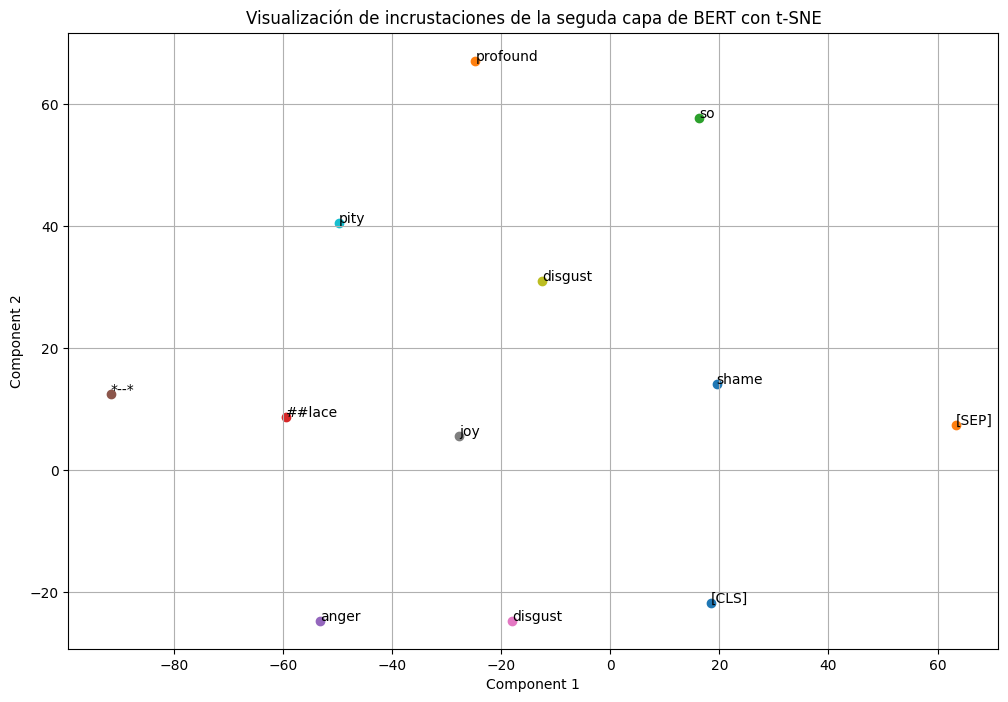

In [ ]:
hidden_state = all_hidden_states[-2].squeeze(0)

tsne = TSNE(n_components=2, perplexity = 10.0, random_state=0)
embeddings_2d = tsne.fit_transform(hidden_state.detach().numpy())

# Plotting
plt.figure(figsize=(12, 8))
for i, token in enumerate(tokens):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title('Visualización de incrustaciones de la seguda capa de BERT con t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

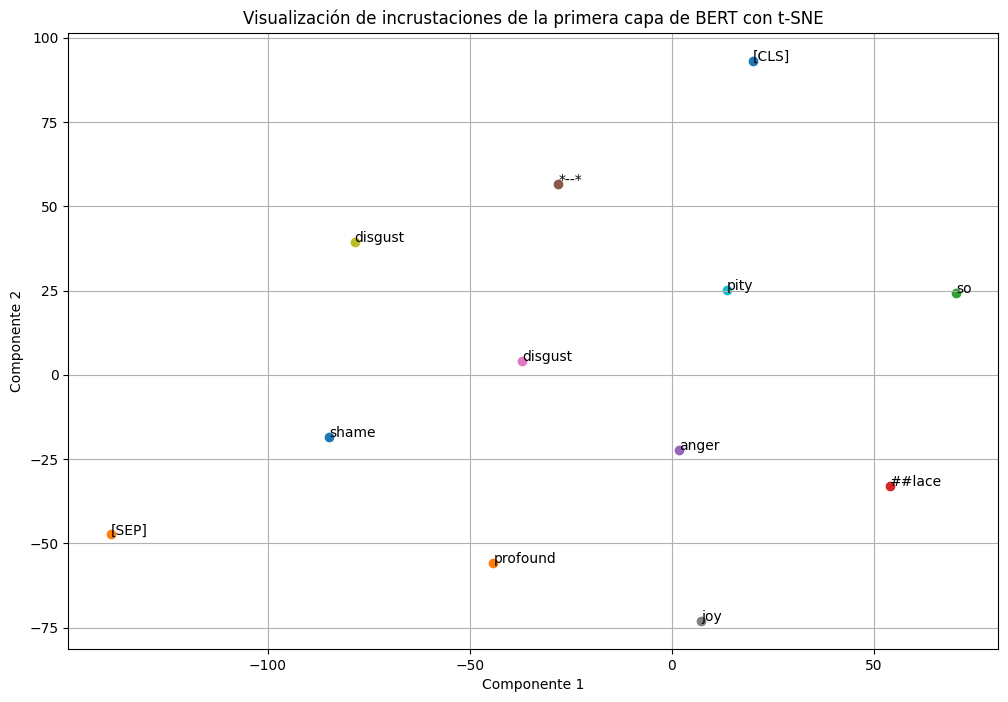

In [ ]:
hidden_state = all_hidden_states[-1].squeeze(0)

tsne = TSNE(n_components=2, perplexity = 10.0, random_state=0)
embeddings_2d = tsne.fit_transform(hidden_state.detach().numpy())

# Plotting
plt.figure(figsize=(12, 8))
for i, token in enumerate(tokens):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title('Visualización de incrustaciones de la primera capa de BERT con t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

In [ ]:
embeddings_2d.shape

(12, 2)

In [ ]:
all_hidden_states[-4].squeeze(0).shape

torch.Size([12, 768])

### Generativo

In [ ]:
cls_hidden_state = last_hidden_state[:, 0, :]

# Initialize the hidden state for GPT-2
# GPT-2 expects a specific shape for input embeddings: (batch_size, sequence_length, hidden_size)
batch_size = cls_hidden_state.shape[0]
sequence_length = 1  # starting with the initial hidden state
hidden_size = cls_hidden_state.shape[1]


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel


In [ ]:
gpt2_model_name = 'gpt2'
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_name)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]